In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from iDirectory import data_dir, sub_dir

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train = pd.read_csv(data_dir + "train.csv", index_col=0)
test = pd.read_csv(data_dir + "test.csv", index_col=0)
orig = pd.read_csv(data_dir + "loan_dataset_20000.csv")

for col in train.select_dtypes(include="object").columns:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")


y = train.iloc[:, -1]
X = train.iloc[:, :-1]
X_pred = test


In [7]:
class Features(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, n_quantiles=5):
        self.n_quantiles = n_quantiles
        self.model = model
        self.suffix_catergory = "_Quartile"
        self.suffix_number = "_risk"
        self.bin_edges_ = {}
        self.target_mean_ = {}
        self.category_mode_ = {}
        self.number_columns_ = None
        self.category_columns_ = None

    def fit(self, df, y=None):
        df = df.copy()
        if isinstance(y, pd.Series):
            y = y.copy()
        else:
            y = pd.Series(data=y, index=df.index, name="y")

        self.number_columns_ = df.select_dtypes(exclude="category").columns
        self.category_columns_ = df.select_dtypes(include="category").columns

        if y is not None:
            df["loan_paid_back"] = y.values
            for col in self.category_columns_:
                self.target_mean_[col] = df.groupby(col, observed=True)["loan_paid_back"].mean()
                self.category_mode_[col] = df[col].mode()

        for col in self.number_columns_:
            # Handle NaNs safely
            series = df[col].dropna()
            try:
                quantiles = np.linspace(0, 1, self.n_quantiles + 1)
                self.bin_edges_[col] = series.quantile(quantiles).values
            except Exception as e:
                print(f"Warning: Could not compute quantiles for {col}: {e}")
                self.bin_edges_[col] = None

        return self

    def transform(self, df):
        df = df.copy()

        if self.model == "category":
            for col in self.number_columns_:
                edges = self.bin_edges_.get(col)
                if edges is None or len(np.unique(edges)) < 2:
                    # skip degenerate columns
                    continue
                labels = [f"Q{i + 1}" for i in range(self.n_quantiles)]
                df[f"{col}{self.suffix_catergory}"] = (
                    pd.cut(df[col], bins=edges, labels=labels, include_lowest=True, duplicates="drop").fillna("Q3").astype("category")
                )

            df = df.select_dtypes(include="category")

        elif self.model == "linear":
            for col in self.category_columns_:
                df[f"{col}{self.suffix_number}"] = df[col].map(self.target_mean_[col]).astype(float)

            df = df.select_dtypes(exclude="category")

        else:
            for col in self.number_columns_:
                edges = self.bin_edges_.get(col)
                if edges is None or len(np.unique(edges)) < 2:
                    # skip degenerate columns
                    continue
                labels = [f"Q{i + 1}" for i in range(self.n_quantiles)]
                df[f"{col}{self.suffix_catergory}"] = (
                    pd.cut(df[col], bins=edges, labels=labels, include_lowest=True, duplicates="drop").fillna("Q3").astype("category")
                )
                for col in self.category_columns_:
                    df[f"{col}{self.suffix_number}"] = df[col].map(self.target_mean_[col]).astype(float)

        return df

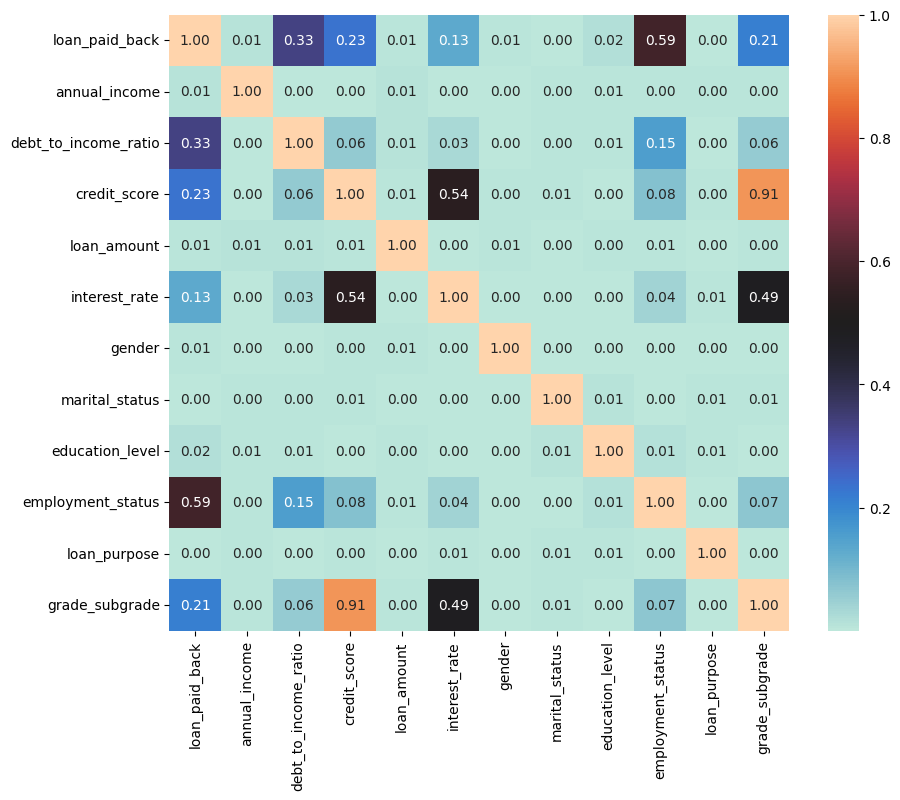

In [8]:
orde = OrdinalEncoder().set_output(transform="pandas")

train_encoded = orde.fit_transform(X, y)
train_encoded = pd.concat([y, train_encoded], axis=1)


plt.figure(figsize=(10, 8))
sns.heatmap(data=train_encoded.corr().abs(), cmap="icefire", annot=True, fmt="0.2f")
plt.show()

In [9]:
xgb = Pipeline(
    [
        (
            "model",
            XGBClassifier(
                random_state=42,
                n_estimators=1500,
                learning_rate=0.03,
                enable_categorical=True,
                device="gpu",
                n_job=7,
            ),
        ),
    ]
)
xgb.fit(X, y)


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='gpu',
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1500, n_job=7, n_jobs=None, ...))])

In [10]:
CatFeatures = Features(model="category").fit_transform(X, y).columns.to_list()
cat = Pipeline([
  ("features", Features(model="category")),
  ("model", CatBoostClassifier(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.5,
    cat_features=CatFeatures,
    verbose=False,
    thread_count=7,
)),])
cat.fit(X, y)


Pipeline(steps=[('features', Features(model='category')),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002591797AD50>)])

In [11]:
lrc = Pipeline([
  ("features", Features(model="linear")),
  ("model", LogisticRegression(
    random_state=42,
    penalty="l2",
    solver="lbfgs",  
    class_weight="balanced",
    max_iter=2000,
    verbose=False,
    n_jobs=7,
)),])

lrc.fit(X, y)

Pipeline(steps=[('features', Features(model='linear')),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    n_jobs=7, random_state=42,
                                    verbose=False))])

In [12]:
xgb_pred = cross_val_predict(xgb, X, y, cv=cv, method="predict_proba")[:, 1]

In [13]:
cat_pred = cross_val_predict(cat, X, y, cv=cv, method="predict_proba")[:, 1]

In [14]:
lrc_pred = cross_val_predict(lrc, X, y, cv=cv, method="predict_proba")[:, 1]


In [15]:

predictionMatrix = pd.DataFrame(
  data={
    "xgb": xgb_pred,
    "cat": cat_pred,
    "lrc": lrc_pred,
  }, 
  index=X.index
)

print(f"XGB - ROC_AUC: {roc_auc_score(y, predictionMatrix["xgb"].round(0))} - Accuracy: {accuracy_score(y, predictionMatrix["xgb"].round(0))}")
print(f"CAT - ROC_AUC: {roc_auc_score(y, predictionMatrix["cat"].round(0))} - Accuracy: {accuracy_score(y, predictionMatrix["cat"].round(0))}")
print(f"LRC - ROC_AUC: {roc_auc_score(y, predictionMatrix["lrc"].round(0))} - Accuracy: {accuracy_score(y, predictionMatrix["lrc"].round(0))}")

XGB - ROC_AUC: 0.7951567439918776 - Accuracy: 0.9047683983339899
CAT - ROC_AUC: 0.7778676722755249 - Accuracy: 0.899626932258575
LRC - ROC_AUC: 0.6745593704902961 - Accuracy: 0.71542810196736


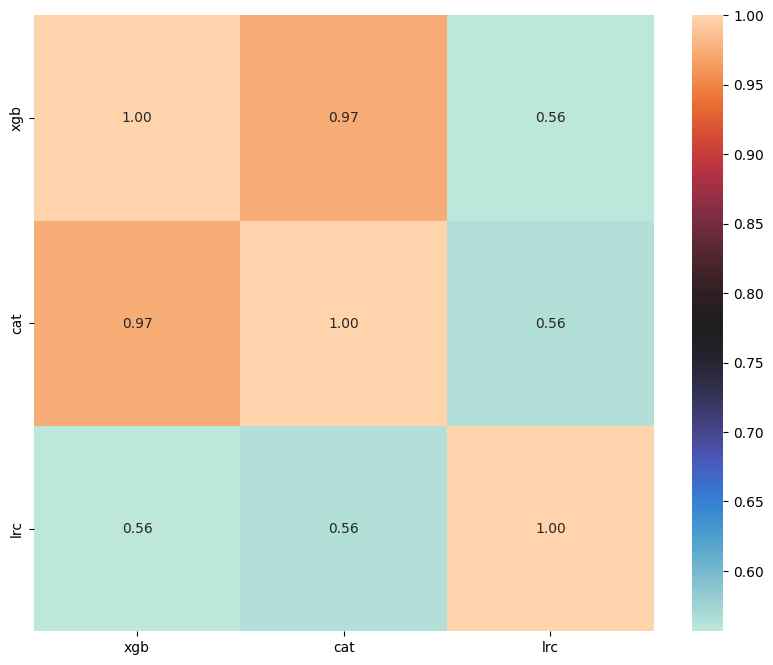

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(data=predictionMatrix.corr().abs(), cmap="icefire", annot=True, fmt="0.2f")
plt.show()

In [21]:
hgb = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=2000,
    learning_rate=0.1
)
hgb.fit(predictionMatrix, y)


HistGradientBoostingClassifier(max_iter=2000, random_state=42)

In [22]:
score_hgb = cross_val_predict(hgb, predictionMatrix, y, cv=cv, method="predict_proba")[:, 1]

print(f"Meta - {roc_auc_score(y, score_hgb.round(0))} - Accuracy: {accuracy_score(y, score_hgb.round(0))}")

Meta - 0.7951048627127707 - Accuracy: 0.9046455014697118


In [19]:
PredProbMatrix = pd.DataFrame(
  data={
    "xgb": xgb.predict_proba(X_pred)[:, 1],
    "cat": cat.predict_proba(X_pred)[:, 1],
    "lrc": lrc.predict_proba(X_pred)[:, 1],
  },
  index=X_pred.index
)

prediction = pd.DataFrame({"Meta":hgb.predict(PredProbMatrix)}, index=X_pred.index)
prediction.reset_index().to_parquet(sub_dir + "submission.parquet")

In [20]:
featureImportance = pd.DataFrame(
  data={
    "feature":xgb.named_steps["model"].feature_importances_ / xgb.named_steps["model"].feature_importances_.max()
  },
  index=xgb.named_steps["model"].feature_names_in_
)
featureImportance

,feature
annual_income,0.004500
debt_to_income_ratio,0.056961
credit_score,0.040695
loan_amount,0.005002
interest_rate,0.004416
gender,0.003339
marital_status,0.003896
education_level,0.004321
employment_status,1.000000
loan_purpose,0.004476
